<a href="https://colab.research.google.com/github/Danilov-Aleksandr/CV_Korpus/blob/master/fashion_mnist_pytorch_(inclass).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задача: обучить модель-классификатор, используя датасет fashionMNIST и фреймворк Pytorch.**

---

In [ ]:
# Импорт библиотек

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

##Загружаем и подготавливаем данные

In [ ]:
!nvidia-smi

Tue Aug 11 15:43:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

fashion MNIST

---
Содержит 60000 + 10000 изображений одежды в черно-белом цвете.

Каждое из изображений принадлежит к одному из классов:

    T-shirt/top
    Trouser
    Pullover
    Dress
    Coat
    Sandal
    Shirt
    Sneaker
    Bag
    Ankle boot


--- 

In [ ]:
#Перед подачей изображений в сеть, нужно сделать некоторые манипуляции
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [ ]:
# Загрузка и разделение данных на train/test в соотношении 60000/10000
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, )

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
print(len(trainset))
print(len(testset))

60000
10000


Примеры изображений из датасета:

tensor([0, 1, 5, 9, 9, 0, 4, 0, 9, 4, 6, 4, 3, 7, 7, 7, 1, 0, 2, 7, 4, 1, 8, 8,
        7, 7, 5, 7, 1, 8, 6, 2, 1, 9, 3, 2, 8, 1, 2, 6, 6, 0, 7, 3, 0, 4, 7, 3,
        0, 5, 9, 8, 8, 4, 8, 1, 2, 2, 2, 3, 1, 6, 8, 2])


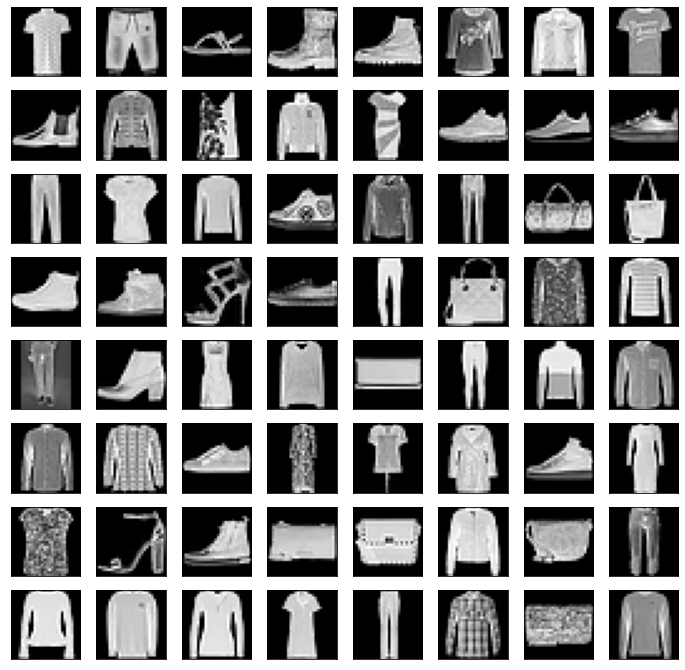

In [ ]:
images, label = next(iter(trainloader))
print(label)
n = len(images)
plt.figure(figsize=(12, 12))
for i, image in enumerate(images[:64]):
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze(), cmap='gray')


In [ ]:
from torch import nn, optim
import torch.nn.functional as F

## Проектируем модель

Простейшая архитектура, которая состоит из одного слоя и 10 нейронов.

In [ ]:
# Инициализируем нашу архитектуру тут. Пока сделаем просто простейшую нейронку из 2х полносвязных слоев.
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256)
        фукнция активации
        дропаут
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Сначала нужно развернуть входную картинку в вектор
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        
        
        return x

Указываем алгоритм оптимизации и функцию потерь

In [ ]:
model = Classifier()
criterion = nn.CrossEntropyLoss() #logsoftmax() + NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9 )

## Тренировка модели

In [ ]:
# Тренируем модель!
epochs = 10
losses = []
for e in range(epochs):
    running_loss = 0
    # загружаем изображения и лейблы из даталоадера
    for images, labels in trainloader:
        #прогоняем батч изображений через модель и получаем батч лейблов
        output = model(images)
        # рассчитываем лосс
        loss = criterion(output, labels)
        # сбрасываем градиенты
        optimizer.zero_grad()
        # делаем обратный проход и расчитываем градиенты
        loss.backward()
        # делаем шаг оптимайзера
        optimizer.step() 
        # посчитаем лосс за каждую эпоху и добавим в лист для вывода графика
        running_loss += loss.item()
    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)
    print(f"Training loss: {epoch_loss}")

Training loss: 0.7398050906879308
Training loss: 0.5185881972249383
Training loss: 0.4793414085912806
Training loss: 0.4584955879207105
Training loss: 0.4453543672747195
Training loss: 0.43690694414222164
Training loss: 0.4290783605468807
Training loss: 0.424357253637141
Training loss: 0.41968204230387834
Training loss: 0.4156296711041729


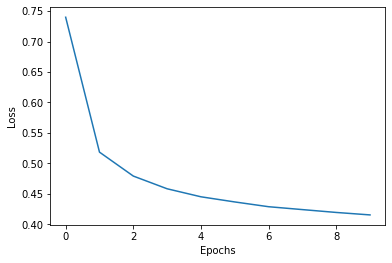

In [ ]:
# выведем график уменьшения нашей лосс функции
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

In [ ]:
# Пора проверить, как же хорошо обучилась наша модель
# Прогоним данные, которые модель не видела, и посчитаем точность.
total = 0
correct = 0
# Зададим параметры, чтобы модель не считала градиенты
with torch.no_grad():
    # переводим модель в режим "оценивания"
    model.eval()
    for images, labels in testloader:
                # прогоняем изображения через модель
            outputs = model(images)
                
                # получим максимальное значение (это и будет наш лейбл)
            predicted = torch.max(outputs.data, 1)[1]
                    
                # Посчитаем количество лейблов
            total += len(labels)

                # Посчитаем количество правильных предиктов
            correct += (predicted == labels).sum()
                
accuracy = 100 * correct / float(total)
print(' Accuracy: {} %'.format(accuracy))

 Accuracy: 83.87999725341797 %


In [ ]:
def view_classify(img, ps):
    ''' Функция для наглядного представления результатов.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


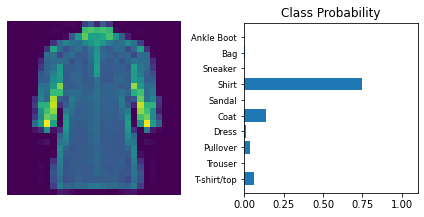

In [ ]:
# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[1]

ps = F.softmax(model(img))

# Plot the image and probabilities
view_classify(img, ps)

## Задания на работу с тьюторами


### ЗАДАНИЕ 1

---

Добавьте дополнительные слои в нейронную сеть. Улучшит ли эти качество модели? Попробуйте подобрать количество слоев, нейронов и функцию активации, которые дадут максимальный эффект.

Напомню основные фукнции активации: Relu, tanh, sigmoid

---



### ЗАДАНИЕ 2

---

Попробуйте подобрать оптимизатор, который повысит точность модели.

---

Варианты оптимизаторов и их параметров (параметры можно менять):
* *sgd(lr=0.0001, momentum=0.99)* - попробуйте поменять параметры
* *adam(lr=0.0001)* -- усовершенстованный алгоритм градиентного спуска, обучает модель быстрее, чем sgd, но любит переобучаться.
* так же можно попробовать другие, которые найдете в документации по запросу torch.optim, их там очень много






### ЗАДАНИЕ 3

---

Уберите подготовку данных (нормализацию и стандартизацию). Как изменилось качество обучения?

---


### ЗАДАНИЕ 4

---
Попробуйте добавить BatchNormalisation и/или Dropout слои в структуру модели. Что получилось?

### Задание 5, плавно переходящее в домашнее задание

---
Поигравшись с заданиями выше попробуйте применить полученные знания и выдать максимальный скор на тестовом датасете комбинируя различные приемы! Можно делиться идеями в чате телеграмма. Обязательно на следующем занятии выясним, смог ли кто-то пересечь черту в 90 процентов точности!